## Toy model for latent variable model in chemical abundance space

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import stan_utils as stan
from mpl_utils import mpl_style, common_limits

plt.style.use(mpl_style)

%matplotlib inline

np.random.seed(42)

In [2]:

def generate_data(N, M, D, scales=None, seed=None):
    """
    Generate some toy data to play with. Here we assume all :math:`N` stars have
    been observed by all :math:`M` surveys.

    :param N:
        The number of stars observed.

    :param M:
        The number of surveys.

    :param D:
        The dimensionality of the label space.

    :param scales: [optional]
        Optional values to provide for the relative scales on the latent factors.

    :param seed: [optional]
        An optional seed to provide to the random number generator.

    :returns:
        A two-length tuple containing the data :math:`y` and a dictionary with
        the true values.
    """

    if seed is not None:
        np.random.seed(seed)

    if scales is None:
        scales = np.abs(np.random.normal(0, 1, size=D))

    else:
        scales = np.array(scales)

    assert len(scales) == D

    X = np.random.normal(
        np.zeros(D),
        scales,
        size=(N, D))

    theta = np.random.normal(0, 1, size=(D, M))

    # TODO: be smrt
    y = np.zeros((N, M, D), dtype=float)
    for i in range(N):
        y[i] = X[i] * theta.T

    # add noise.
    psi = np.abs(np.random.normal(0, 0.1, size=D))
    phi = np.abs(np.random.normal(0, 0.1, size=(M, D)))

    rank = scales * np.random.normal(0, 1, size=y.shape)

    noise = np.zeros_like(y)
    for m in range(M):
        noise[:, m] = rank[:, m] * (phi[m] + psi)

    y += noise

    truths = dict(X=X, theta=theta.T, psi=psi, phi=phi.T, scales=scales)

    return (y, truths)

In [3]:
# Generate some data.
N, M, D = (256, 3, 5)
# TODO: use scales.
#scales = [250, 0.2, 0.1, 0.1, 0.1] 
scales = np.ones(D)

y, truths = generate_data(N=N, M=M, D=D, scales=scales)

In [4]:
# Construct a model and optimize it (from the true values).
model = stan.read_model("toy_model.stan")

data = dict(y=y, N=N, M=M, D=D, scales=scales)
init = dict(X=truths["X"], theta=truths["theta"], psi=truths["psi"],
            phi=truths["phi"])

op_kwds = dict(
    data=data, 
    iter=100000, 
    tol_obj=7./3 - 4./3 - 1, # machine precision
    tol_grad=7./3 - 4./3 - 1, # machine precision
    tol_rel_grad=1e3,
    tol_rel_obj=1e4
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d7170a4b1b9257b3a7eb9e4200985f3a NOW.


In [5]:
# initialize from true position
p_opt_ft = model.optimizing(init=init, **op_kwds)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [6]:
# initialize from a random position.
p_opt_fr = model.optimizing(**op_kwds)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
def _geometric_reflection(truths, optimized):
    """
    Check the optimized values of :math:`X` and :math:`\theta` across different
    dimensions, and if necessary, reflect the values in the optimized result.
    """

    N, D = truths["X"].shape
    reflected = np.zeros(D, dtype=bool)

    for d in range(D):
        x = truths["X"].T[d]
        y = optimized["X"].T[d]

        A = np.vstack((np.ones_like(x), x)).T
        C = np.eye(N)

        cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
        b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

        if m_ls < 0:
            # reflect!
            reflected[d] = True
            optimized["X"].T[d] *= -1
            optimized["theta"].T[d] *= -1

            print("reflecting on index = {}".format(d))

    # C
    return None

# Do geometric reflections as necessary
_geometric_reflection(truths, p_opt_ft)
_geometric_reflection(truths, p_opt_fr)

reflecting on index = 0
reflecting on index = 3


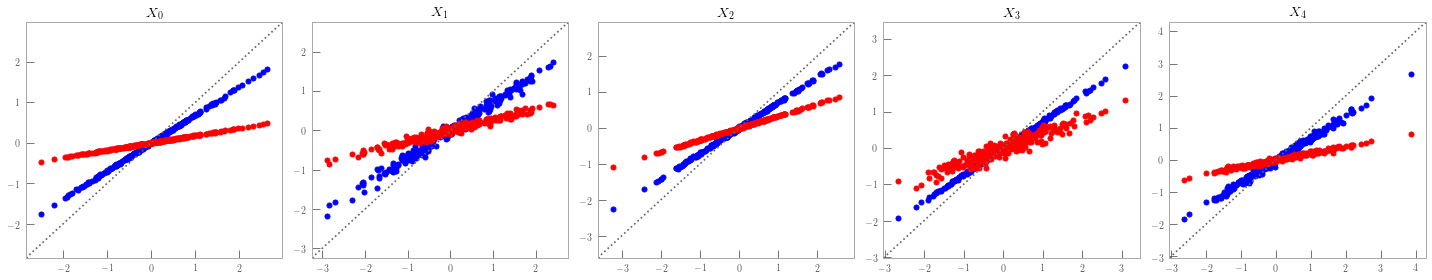

In [9]:
fig, axes = plt.subplots(1, D, figsize=(4 * D, 4))
for d, ax in enumerate(axes):

    x = truths["X"].T[d]
    y_ft = p_opt_ft["X"].T[d]
    y_fr = p_opt_fr["X"].T[d]

    ax.scatter(x, y_ft, facecolor="b")
    ax.scatter(x, y_fr, facecolor="r")

    ax.set_title(r"$X_{{{0}}}$".format(d))

    common_limits(ax, plot_one_to_one=True)

fig.tight_layout()

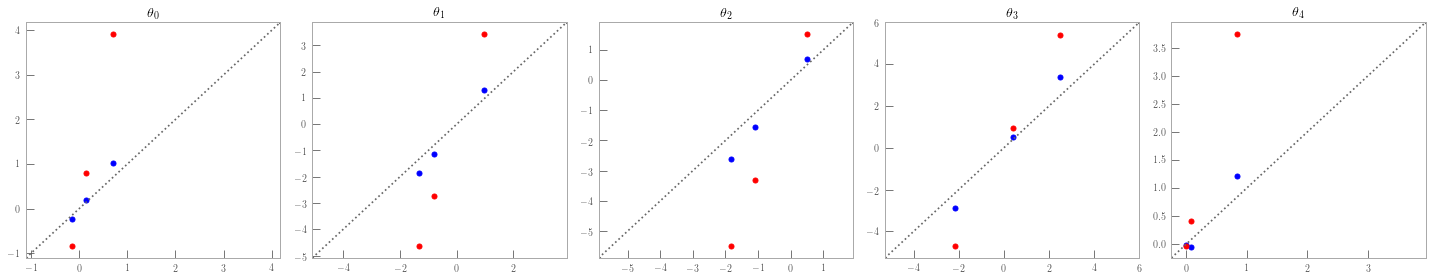

In [10]:
fig, axes = plt.subplots(1, D, figsize=(4 * D, 4))
for d, ax in enumerate(axes):

    x = truths["theta"].T[d]
    y_ft = p_opt_ft["theta"].T[d]
    y_fr = p_opt_fr["theta"].T[d]

    ax.scatter(x, y_ft, facecolor="b")
    ax.scatter(x, y_fr, facecolor="r")

    ax.set_title(r"$\theta_{{{0}}}$".format(d))

    common_limits(ax, plot_one_to_one=True)

fig.tight_layout()

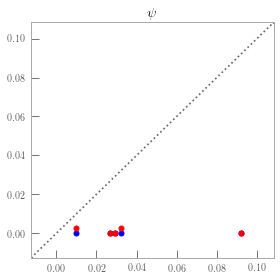

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

x = truths["psi"]
y_ft = p_opt_ft["psi"]
y_fr = p_opt_fr["psi"]

ax.scatter(x, y_ft, facecolor="b")
ax.scatter(x, y_fr, facecolor="r")
ax.set_title(r"$\psi$")
common_limits(ax, plot_one_to_one=True)

fig.tight_layout()

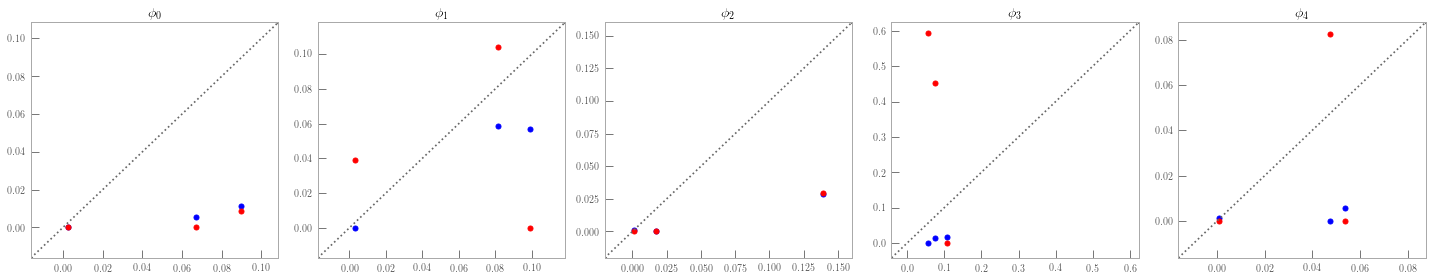

In [12]:
fig, axes = plt.subplots(1, D, figsize=(4 * D, 4))
for d, ax in enumerate(axes):

    x = truths["phi"][d]
    y_ft = p_opt_ft["phi"][d]
    y_fr = p_opt_fr["phi"][d]

    ax.scatter(x, y_ft, facecolor="b")
    ax.scatter(x, y_fr, facecolor="r")

    ax.set_title(r"$\phi_{{{0}}}$".format(d))
    common_limits(ax, plot_one_to_one=True)

fig.tight_layout()